# Fusion des embeddings et recherche de sosies

## Objectif
Ce notebook a pour but de construire la base finale de reconnaissance faciale
en fusionnant les embeddings issus du dataset FairFace et des photos personnelles.

À partir de cette base, une recherche par similarité est réalisée afin de retrouver
les visages les plus proches d’une image requête.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
BASE_DIR = Path("../data/processed")

emb_fairface = np.load(BASE_DIR / "embeddings_fairface.npy")
emb_our = np.load(BASE_DIR / "embeddings_our_faces.npy")

print("FairFace :", emb_fairface.shape)
print("Photos personnelles :", emb_our.shape)

FairFace : (84987, 512)
Photos personnelles : (35, 512)


## Fusion des embeddings

In [3]:
embeddings = np.vstack([emb_fairface, emb_our])
print("Base finale :", embeddings.shape)

Base finale : (85022, 512)


In [4]:
np.save(BASE_DIR / "embeddings.npy", embeddings)
print("embeddings.npy sauvegardé")

embeddings.npy sauvegardé


## Construction des métadonnées

In [5]:
meta = []

# FairFace
fairface_imgs = list((Path("../data/processed/fairface_faces")).glob("*.jpg"))
for i, p in enumerate(fairface_imgs):
    meta.append({
        "index": i,
        "filename": p.name,
        "path": str(p),
        "source": "fairface",
        "identity": ""
    })

# Photos personnelles
start = len(meta)
for person_dir in (Path("../data/processed/our_faces")).iterdir():
    if not person_dir.is_dir():
        continue
    for img in person_dir.glob("*.jpg"):
        meta.append({
            "index": start,
            "filename": img.name,
            "path": str(img),
            "source": "our_faces",
            "identity": person_dir.name
        })
        start += 1

meta_df = pd.DataFrame(meta)
meta_df.to_csv(BASE_DIR / "meta.csv", index=False)

meta_df.head()

,index,filename,path,source,identity
0,0,1.jpg,..\data\processed\fairface_faces\1.jpg,fairface,
1,1,10.jpg,..\data\processed\fairface_faces\10.jpg,fairface,
2,2,100.jpg,..\data\processed\fairface_faces\100.jpg,fairface,
3,3,1000.jpg,..\data\processed\fairface_faces\1000.jpg,fairface,
4,4,10000.jpg,..\data\processed\fairface_faces\10000.jpg,fairface,


## Chargement d’une image requête

(np.float64(-0.5), np.float64(159.5), np.float64(159.5), np.float64(-0.5))

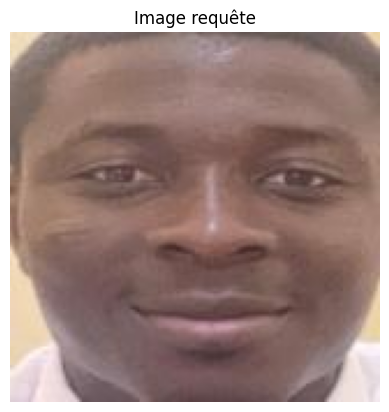

In [6]:
# Exemple : on prend une image personnelle comme requête
query_path = Path("../data/processed/our_faces/Diaby").glob("*.jpg")
query_path = list(query_path)[0]

query_img = Image.open(query_path).convert("RGB")
plt.imshow(query_img)
plt.title("Image requête")
plt.axis("off")

## Extraction de l’embedding requête

In [7]:
from facenet_pytorch import InceptionResnetV1
import torch
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model = InceptionResnetV1(pretrained="vggface2").to(device).eval()

preprocess = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

x = preprocess(query_img).unsqueeze(0).to(device)
with torch.no_grad():
    query_emb = model(x).cpu().numpy().flatten()

query_emb = query_emb / np.linalg.norm(query_emb)

d:\Mes_dossiers\IDSI\M2\Course\RN & DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Mes_dossiers\IDSI\M2\Course\RN & DL\.venv\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the us

## Recherche par similarité cosinus

In [8]:
sims = cosine_similarity(query_emb.reshape(1, -1), embeddings)[0]

meta_df["similarity"] = sims
top_k = meta_df.sort_values("similarity", ascending=False).head(5)

top_k

,index,filename,path,source,identity,similarity
85004,85004,WhatsApp Image 2025-12-13 at 02.12.22_190bbfd0...,..\data\processed\our_faces\Diaby\WhatsApp Ima...,our_faces,Diaby,1.000000
85006,85006,WhatsApp Image 2025-12-13 at 02.12.22_55851b0a...,..\data\processed\our_faces\Diaby\WhatsApp Ima...,our_faces,Diaby,0.839957
85011,85011,WhatsApp Image 2025-12-13 at 02.12.22_d56e21eb...,..\data\processed\our_faces\Diaby\WhatsApp Ima...,our_faces,Diaby,0.830233
85009,85009,WhatsApp Image 2025-12-13 at 02.12.22_b0369754...,..\data\processed\our_faces\Diaby\WhatsApp Ima...,our_faces,Diaby,0.816337
85007,85007,WhatsApp Image 2025-12-13 at 02.12.22_7218fe27...,..\data\processed\our_faces\Diaby\WhatsApp Ima...,our_faces,Diaby,0.810985


## Visualisation des sosies

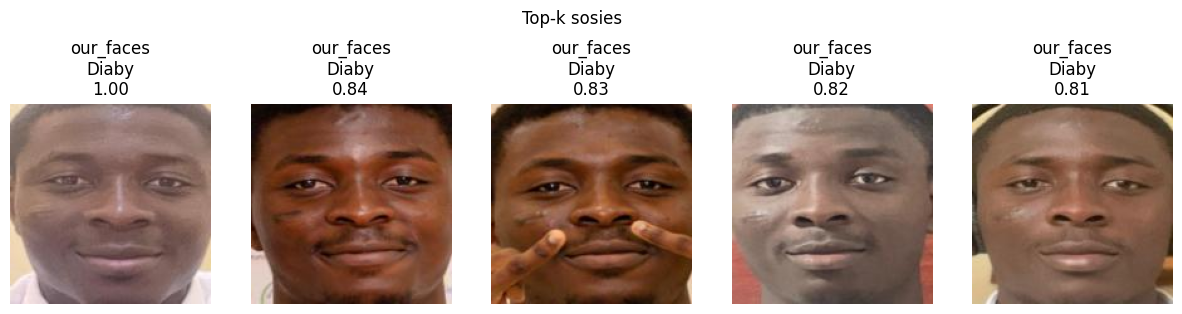

In [9]:
fig, axes = plt.subplots(1, len(top_k), figsize=(15,4))

for ax, (_, row) in zip(axes, top_k.iterrows()):
    img = Image.open(row["path"]).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"{row['source']}\n{row['identity']}\n{row['similarity']:.2f}")
    ax.axis("off")

plt.suptitle("Top-k sosies")
plt.show()